In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib

Generiamo un databse sintetizzato

In [2]:
np.random.seed(42)

# Function for creating datapoints in the form of a circle
def PointsInCircum(r,n=100):
    return [(math.cos(2*math.pi/n*x)*r+np.random.normal(-30,30),math.sin(2*math.pi/n*x)*r+np.random.normal(-30,30)) for x in range(1,n+1)]

In [3]:
# Creating data points in the form of a circle
df=pd.DataFrame(PointsInCircum(500,1000))
df=df.append(PointsInCircum(300,700))
df=df.append(PointsInCircum(100,300))

# Adding noise to the dataset
df=df.append([(np.random.randint(-600,600),np.random.randint(-600,600)) for i in range(300)])
df

,0,1
0,484.891555,-31.006357
1,489.391178,21.973916
2,462.886575,-27.599889
3,517.218479,5.588090
4,455.669049,1.982181
...,...,...
295,-229.000000,-504.000000
296,392.000000,-580.000000
297,134.000000,525.000000
298,469.000000,-535.000000


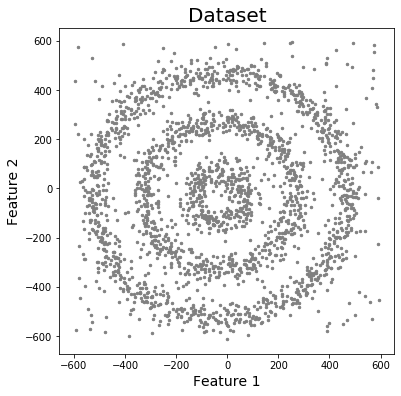

In [4]:
plt.figure(figsize=(6, 6))
plt.scatter(df[0],df[1],s=6,color='grey')
plt.title('Dataset',fontsize=20)
plt.xlabel('Feature 1',fontsize=14)
plt.ylabel('Feature 2',fontsize=14)
plt.show()

# K-Means

Proviamo con k-means impostando un numero di cluster pari a 3

In [5]:
from sklearn.cluster import KMeans
k_means=KMeans(n_clusters=3,random_state=42)
k_means.fit(df[[0,1]])

KMeans(n_clusters=3, random_state=42)

In [6]:
df['KMeans_labels']=k_means.labels_
df['KMeans_labels'].value_counts()

2    784
0    767
1    749
Name: KMeans_labels, dtype: int64

In [7]:
def plot_figure(title, colors, df, label):
    plt.figure(figsize=(6, 6))
    plt.scatter(df[0],df[1],c=label,cmap=matplotlib.colors.ListedColormap(colors),s=6)
    plt.title(title,fontsize=20)
    plt.xlabel('Feature 1',fontsize=14)
    plt.ylabel('Feature 2',fontsize=14)
    plt.show()

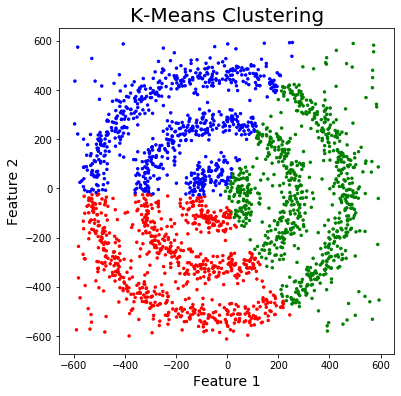

In [8]:
# Plotting resulting clusters
colors=['red','blue','green']

plot_figure("K-Means Clustering", colors, df, df['KMeans_labels'])

k-Means ha partizionato lo spazio in tre fette e non ha identificato correttamente i cluster concentrici

# Clustering agglomerativo

In [25]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean')
model.fit(df[[0,1]])

AgglomerativeClustering(n_clusters=3)

In [26]:
df['HR_labels']=model.labels_
df['HR_labels'].value_counts()

0    1207
1     575
2     518
Name: HR_labels, dtype: int64

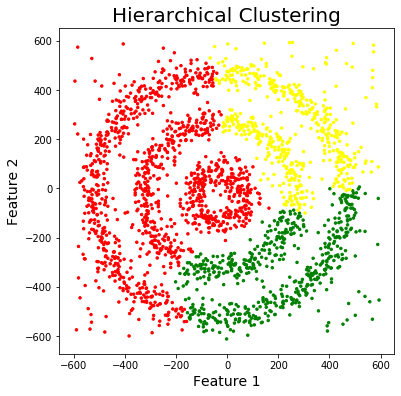

In [27]:
# Plotting resulting clusters
plot_figure("Hierarchical Clustering", colors, df, df['HR_labels'])

Risultato molto simile al precedente

# DBSCAN

In [12]:
from sklearn.cluster import DBSCAN
dbscan=DBSCAN()
dbscan.fit(df[[0,1]])

DBSCAN()

In [13]:
df['DBSCAN_labels']=dbscan.labels_
df['DBSCAN_labels'].value_counts()

-1    2300
Name: DBSCAN_labels, dtype: int64

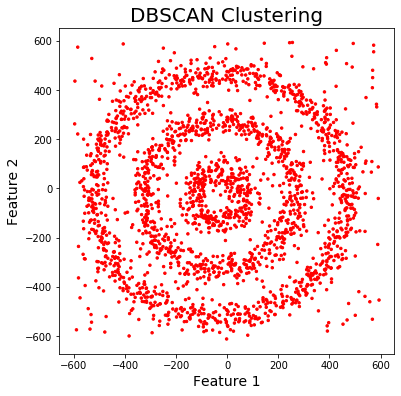

In [14]:
# Plotting resulting clusters
plot_figure("DBSCAN Clustering", colors, df, df['DBSCAN_labels'])

Tutti outliers, probabilmente epsilon troppo piccolo. Usiamo il 4-dist graph per determinare un corretto valore per epsilon

In [15]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(df[[0,1]])
distances, indices = nbrs.kneighbors(df[[0,1]])
distances

array([[ 0.        ,  6.91861074, 12.31149451, 14.24353287],
       [ 0.        , 10.80836526, 19.01534865, 24.14726459],
       [ 0.        ,  7.56030267,  9.95689913, 10.74785574],
       ...,
       [ 0.        , 25.77071121, 34.73183904, 40.21517379],
       [ 0.        , 23.34523506, 37.21558813, 67.26812024],
       [ 0.        , 37.73592453, 52.17278984, 60.17867661]])

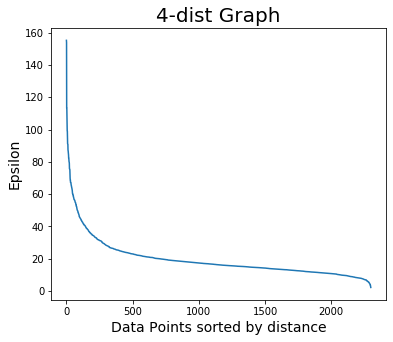

In [16]:
# Plotting K-distance Graph
dist4 = distances[:,3]
dist4 = np.sort(dist4, axis=0)[::-1]
plt.figure(figsize=(6,5))
plt.plot(dist4)

plt.title('4-dist Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

La massima curvatura si ha all'incirca per epsilon = 33, sensibilmente maggiore rispetto a 0.5 usato in precedenza.

In [17]:
from sklearn.cluster import DBSCAN
dbscan_opt=DBSCAN(eps=33,min_samples=4)
dbscan_opt.fit(df[[0,1]])

DBSCAN(eps=33, min_samples=4)

In [18]:
df['DBSCAN_opt_labels']=dbscan_opt.labels_
df['DBSCAN_opt_labels'].value_counts()

 0    1076
 1     759
 2     320
-1     141
 3       4
Name: DBSCAN_opt_labels, dtype: int64

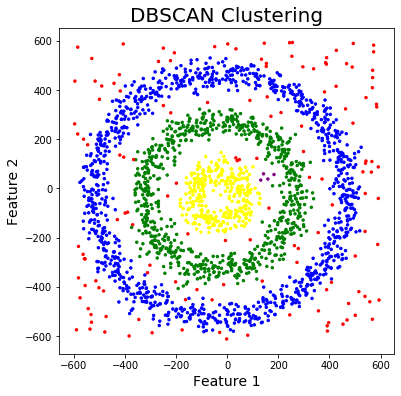

In [19]:
# Plotting the resulting clusters
colors=['red','blue','green','yellow', 'purple']
plot_figure("DBSCAN Clustering", colors, df, df['DBSCAN_opt_labels'])

Aumentiamo a 6 il numero minimo di sample per evitare di prendere il cluster da 4 punti viola

In [20]:
from sklearn.cluster import DBSCAN
dbscan_opt=DBSCAN(eps=33,min_samples=6)
dbscan_opt.fit(df[[0,1]])
df['DBSCAN_opt_labels']=dbscan_opt.labels_
df['DBSCAN_opt_labels'].value_counts()

 0    1061
 1     751
 2     320
-1     168
Name: DBSCAN_opt_labels, dtype: int64

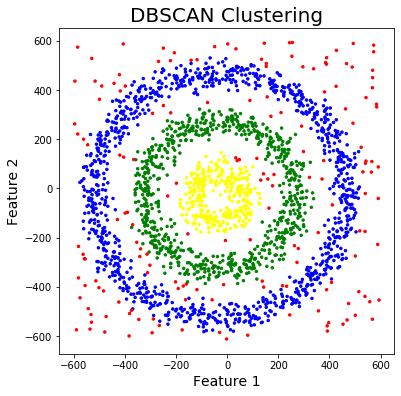

In [21]:
colors=['red','blue','green','yellow']
plot_figure("DBSCAN Clustering", colors, df, df['DBSCAN_opt_labels'])

Abbiamo clusterizzato in modo corretto lo spazio